In [1]:
#Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Imports for arithmetic calculations and data frame manipulation
import math
import numpy as np
import pandas as pd

#Imports for creating visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Imports for preprocessing
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

#Imports for modeling and evaluation
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE


#Imports for user defined functions
import wrangle as wr
import explore as ex
import evaluate as ev

## Acquire Prepped Data

In [2]:
train, validate, test = wr.wrangle_zillow_mvp()
train.shape, validate.shape, test.shape

Using cached csv...


((25550, 6), (10950, 6), (9126, 6))

## Data Preprocessing

#### Project Reminder:
"For the first iteration of your model, use only square feet of the home, number of bedrooms, and number of bathrooms to estimate the property's assessed value, taxvaluedollarcnt. You can expand this to other fields after you have completed an mvp (minimally viable product)."

- I will create my X and Y groups accordingly to reach an MVP

In [3]:
train.columns

Index(['bedrooms', 'bathrooms', 'year_built', 'square_feet', 'county',
       'assessed_value'],
      dtype='object')

(<Figure size 1152x648 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'bedrooms before scaling'}, xlabel='bedrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bedrooms after scaling with MinMaxScaler'}, xlabel='bedrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'bathrooms before scaling'}, xlabel='bathrooms', ylabel='count'>,
         <AxesSubplot:title={'center':'bathrooms after scaling with MinMaxScaler'}, xlabel='bathrooms', ylabel='count'>],
        [<AxesSubplot:title={'center':'square_feet before scaling'}, xlabel='square_feet', ylabel='count'>,
         <AxesSubplot:title={'center':'square_feet after scaling with MinMaxScaler'}, xlabel='square_feet', ylabel='count'>]],
       dtype=object))

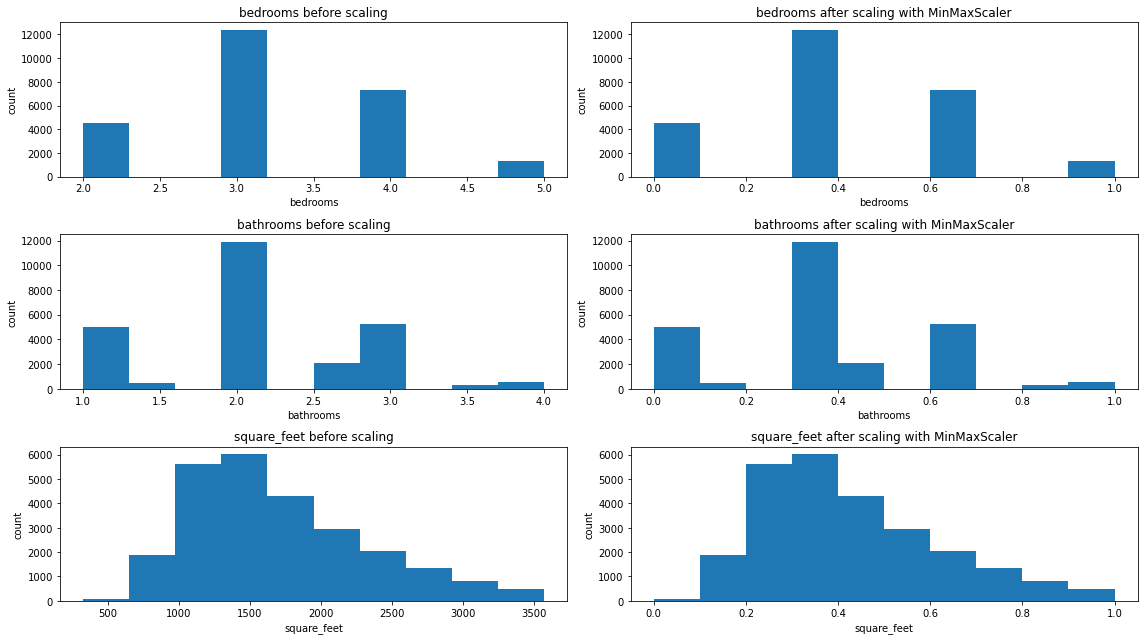

In [4]:
# Visualize scaling of data before actually scaling
wr.visualize_scaler(scaler=MinMaxScaler(), df=train, target_columns = ['bedrooms', 'bathrooms', 'square_feet'])

**Distributions seem to be similar so I'll move forward using the MinMaxScaler.**

In [5]:
# Scale data using MinMax Scaler
train_scaled, validate_scaled, test_scaled = wr.scale_data_mvp(train, validate, test)

In [6]:
train_scaled.shape, validate_scaled.shape, test_scaled.shape

((25550, 6), (10950, 6), (9126, 6))

In [7]:
#First Iteration - split into X and Y using scaled data
X_train, y_train = train_scaled.drop(columns=['assessed_value', 'year_built', 'county']), train_scaled.assessed_value
X_validate, y_validate = validate_scaled.drop(columns=['assessed_value', 'year_built', 'county']), validate_scaled.assessed_value
X_test, y_test = test_scaled.drop(columns=['assessed_value', 'year_built', 'county']), test_scaled.assessed_value

In [8]:
# Sanity Check 
X_train.columns, y_train.head()

(Index(['bedrooms', 'bathrooms', 'square_feet'], dtype='object'),
 17219    296809
 36164    938664
 16548    766513
 29763    464414
 22852    117601
 Name: assessed_value, dtype: int64)

In [9]:
# Sanity check
X_train.head()

,bedrooms,bathrooms,square_feet
17219,0.666667,0.333333,0.488128
36164,0.333333,0.666667,0.873574
16548,0.666667,0.666667,0.770583
29763,0.333333,0.333333,0.315757
22852,0.000000,0.000000,0.127660


### Calculate our baseline
- Will caculate baseline based on both the mean and median and evaluate which has the lowest RMSE to decide which will be the baseline to beat.

In [10]:
#First convert y_train into Dataframes so the baselines can be easily calculated with pandas
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_test =pd.DataFrame(y_test)

# Create new data frame to hold my in sample predictions and the same for out of sample
predictions_train = y_train.copy()
predictions_train = predictions_train.rename(columns={'assessed_value':'actual'})
predictions_validate = y_validate.copy()
predictions_validate = predictions_validate.rename(columns={'assessed_value':'actual'})
predictions_test = y_test.copy()
predictions_test = predictions_test.rename(columns={'assessed_value':'actual'})


#Calculate based on mean and add baseline predictions to a the train data frame holding predictions
baseline_mean = y_train.assessed_value.mean()
predictions_train['baseline_mean'] = baseline_mean
predictions_validate['baseline_mean'] = baseline_mean
predictions_test['baseline_mean'] = baseline_mean

#Calculate based on median and add baseline predictions to the train data frame holding predictions
baseline_median = y_train.assessed_value.median()
predictions_train['baseline_median'] = baseline_median
predictions_validate['baseline_median'] = baseline_median
predictions_test['baseline_median'] = baseline_median

#Sanity Check
predictions_train.head()

,actual,baseline_mean,baseline_median
17219,296809,372474.293464,337220.5
36164,938664,372474.293464,337220.5
16548,766513,372474.293464,337220.5
29763,464414,372474.293464,337220.5
22852,117601,372474.293464,337220.5


In [11]:
# Calculate RMSE based on mean 
ev.rmse(predictions_train.actual, predictions_train.baseline_mean)

243610.20860463442

In [12]:
# Calculate RMSE based on median 
ev.rmse(predictions_train.actual, predictions_train.baseline_median)

246147.84924914845

**Since the mean baseline has a lower RMSE, I will use it as the baseline to evaluate my models against.**

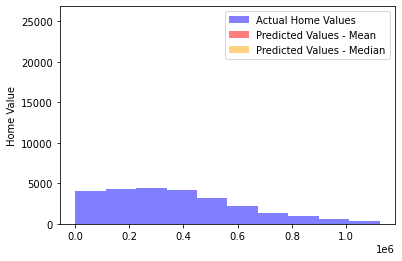

In [13]:
# Visualize baseline performance
# plot to visualize actual vs predicted. 
plt.hist(predictions_train.actual, color='blue', alpha=.5, label="Actual Home Values")
plt.hist(predictions_train.baseline_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Values - Mean")
plt.hist(predictions_train.baseline_median, bins=1, color='orange', alpha=.5, rwidth=100, label="Predicted Values - Median")
plt.ylabel("Home Value")
plt.legend()
plt.show()

## Create Linear Regression Models

### Model 1 - Simple Model (Ordinary Least Squares)

In [14]:
## Model 1 - Simple Model -- Ordinary Least Squares

#Create model
lm = LinearRegression(normalize = True)

#Fit model to train
lm.fit(X_train, y_train)

#Make predictions on test, validate
predictions_train['ols_model'] = lm.predict(X_train)
predictions_validate['ols_model'] = lm.predict(X_validate)

# Calculate RMSE
train_rmse1 = ev.rmse(predictions_train.actual, predictions_train.ols_model)
validate_rmse1 = ev.rmse(predictions_validate.actual, predictions_validate.ols_model)

#Calculate R2 Score
r2_train1 = r2_score(predictions_train.actual, predictions_train.ols_model)
r2_validate1 = r2_score(predictions_validate.actual, predictions_validate.ols_model)


print("RMSE using OLS\nTrain/In-Sample: ", train_rmse1, 
      "\nValidate/Out-of-Sample: ", validate_rmse1)

print("R2 Score using OLS\nTrain/In-Sample: ", r2_train1, 
      "\nValidate/Out-of-Sample: ", r2_validate1)

RMSE using OLS
Train/In-Sample:  216208.35984505145 
Validate/Out-of-Sample:  217786.84364376287
R2 Score using OLS
Train/In-Sample:  0.21231242102404468 
Validate/Out-of-Sample:  0.21464951956938927


In [15]:
# Calculate accuracy on validate
lm.score(X_train, y_train)

0.21231242102404468

In [16]:
# Is it better than baseline?
ev.better_than_baseline(predictions_train.actual, predictions_train.ols_model)

True

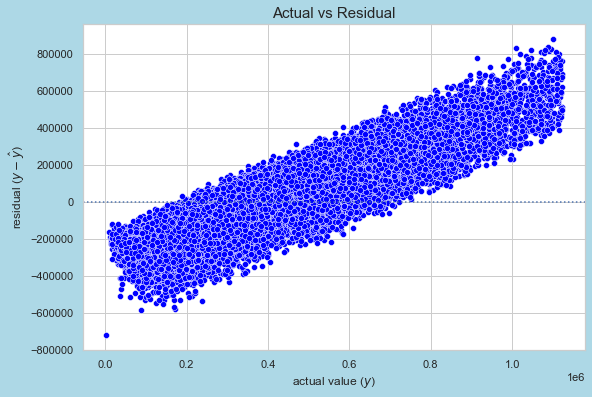

In [17]:
# Visualize by plotting residuals
ev.plot_residuals(predictions_train.actual, predictions_train.ols_model, predictions_train)

### Model 2 - LASSO + LARS

In [18]:
## Model 2 -- Set up a loop that creates LassoLars models using different values for the alpha

for i in range(1, 25, 5):
    #Create model
    lars = LassoLars(alpha = i)
    
    #Fit model
    lars.fit(X_train, y_train)
    
    #Make predictions and add to data frame
    predictions_train[f'lars_alpha_{i}'] = lars.predict(X_train)
    predictions_validate[f'lars_alpha_{i}'] = lars.predict(X_validate)
    #Calculate RMSE
    train_rmse = ev.rmse(predictions_train.actual, predictions_train[f'lars_alpha_{i}'])
    validate_rmse = ev.rmse(predictions_validate.actual, predictions_validate[f'lars_alpha_{i}'])
    
    print(f'\nRMSE using LassoLars, alpha = {i}')
    print("Train/In-Sample: ", round(train_rmse, 2),
    "\nValidate/Out-of-Sample: ", round(validate_rmse, 2))



RMSE using LassoLars, alpha = 1
Train/In-Sample:  216208.7 
Validate/Out-of-Sample:  217788.65

RMSE using LassoLars, alpha = 6
Train/In-Sample:  216220.57 
Validate/Out-of-Sample:  217807.8

RMSE using LassoLars, alpha = 11
Train/In-Sample:  216249.4 
Validate/Out-of-Sample:  217843.78

RMSE using LassoLars, alpha = 16
Train/In-Sample:  216295.18 
Validate/Out-of-Sample:  217896.59

RMSE using LassoLars, alpha = 21
Train/In-Sample:  216357.91 
Validate/Out-of-Sample:  217966.2


Note:
- The smaller the value for alpha the better the models perform. 
- I will use the LassoLars model with and alpha of 1 and drop the rest from my predictions data frame.

In [19]:
predictions_train.columns

Index(['actual', 'baseline_mean', 'baseline_median', 'ols_model',
       'lars_alpha_1', 'lars_alpha_6', 'lars_alpha_11', 'lars_alpha_16',
       'lars_alpha_21'],
      dtype='object')

In [20]:
# Drop the extra lars model predictions
predictions_train.drop(columns=['lars_alpha_6', 'lars_alpha_11', 'lars_alpha_16', 'lars_alpha_21'], inplace=True)
predictions_validate.drop(columns=['lars_alpha_6', 'lars_alpha_11', 'lars_alpha_16', 'lars_alpha_21'], inplace=True)
#sanity check
predictions_train.head()

,actual,baseline_mean,baseline_median,ols_model,lars_alpha_1
17219,296809,372474.293464,337220.5,375658.842208,376043.951273
36164,938664,372474.293464,337220.5,671195.762139,670194.677496
16548,766513,372474.293464,337220.5,571262.455466,570964.132495
29763,464414,372474.293464,337220.5,313468.939009,313532.585119
22852,117601,372474.293464,337220.5,212715.261900,212771.533989


In [21]:
# Re-calculate RMSE for single model
train_rmse2 = ev.rmse(predictions_train.actual, predictions_train.lars_alpha_1)
validate_rmse2 = ev.rmse(predictions_validate.actual, predictions_validate.lars_alpha_1)

print(f'\nRMSE using LassoLars')
print("Train/In-Sample: ", round(train_rmse2, 2),
      "\nValidate/Out-of-Sample: ", round(validate_rmse2, 2))


RMSE using LassoLars
Train/In-Sample:  216208.7 
Validate/Out-of-Sample:  217788.65


In [22]:
# Is it better than baseline?
ev.better_than_baseline(predictions_train.actual, predictions_train.lars_alpha_1)

True

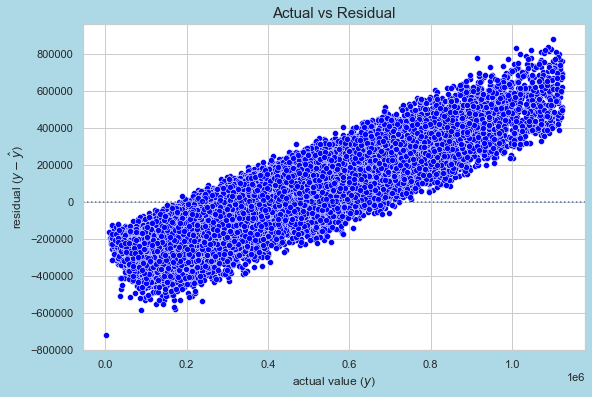

In [23]:
# Visualize by plotting residuals
ev.plot_residuals(predictions_train.actual, predictions_train.lars_alpha_1, predictions_train)

### Model 3 - Polynomial Regression

In [24]:
## Create the polynomial features

# Create polynomial features
pf = PolynomialFeatures(degree=2)

# fit to my features and create a new version of X_train with transformed features
X_train_poly = pf.fit_transform(X_train)

# Transform features on X_validate and X_test
X_validate_poly = pf.transform(X_validate)
X_test_poly = pf.transform(X_test)

In [25]:
## Create another simple linear regression model

#Create model
lm2 = LinearRegression(normalize=True)

# Fit to training set with polynomial features
lm2.fit(X_train_poly, y_train)

# Make predictions on train and validate
predictions_train['polynomial_model'] = lm2.predict(X_train_poly)
predictions_validate['polynomial_model'] = lm2.predict(X_validate_poly)

# Calculate RMSE
train_rmse3 = ev.rmse(predictions_train.actual, predictions_train.polynomial_model)
validate_rmse3 = ev.rmse(predictions_validate.actual, predictions_validate.polynomial_model)

print("RMSE using Polynomial Features\nTrain/In-Sample: ", round(train_rmse3, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_rmse3, 2))

RMSE using Polynomial Features
Train/In-Sample:  216040.7 
Validate/Out-of-Sample:  217801.43


In [26]:
# Is it better than baseline?
ev.better_than_baseline(predictions_train.actual, predictions_train.polynomial_model)

True

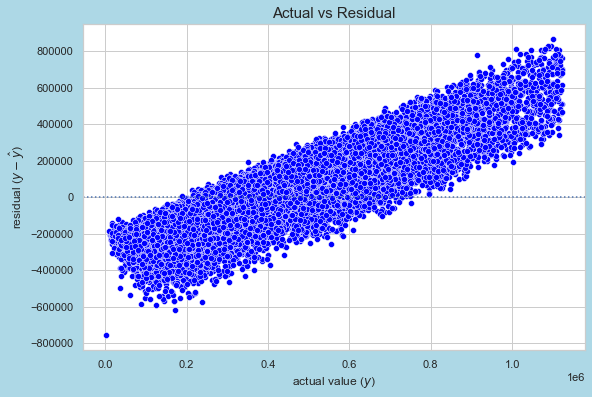

In [27]:
# Visualize by plotting residuals
ev.plot_residuals(predictions_train.actual, predictions_train.polynomial_model, predictions_train)

### Model 4 - Generalized Linear Model

In [28]:
# create the model
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to training data
glm.fit(X_train, y_train)

# make predictions on validate
predictions_train['glm'] = glm.predict(X_train)
predictions_validate['glm'] = glm.predict(X_validate)

# Calculate RMSE
train_rmse4 = ev.rmse(predictions_train.actual, predictions_train.glm)
validate_rmse4 = ev.rmse(predictions_validate.actual, predictions_validate.glm)

print("RMSE using Generalized Linear Model\nTrain/In-Sample: ", round(train_rmse4, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_rmse4, 2))

RMSE using Generalized Linear Model
Train/In-Sample:  216461.09 
Validate/Out-of-Sample:  218190.72


## Choosing Best Model (MVP)

#### Compare all RMSE Scores

In [29]:
# Comparing all models side by side
print("RMSE using OLS\nTrain/In-Sample: ", round(train_rmse1, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_rmse1, 2))
print('----------------------------------------------------')
print('RMSE using LassoLars\nTrain/In-Sample: ', round(train_rmse2, 2),
      "\nValidate/Out-of-Sample: ", round(validate_rmse2, 2))
print('----------------------------------------------------')
print("RMSE using Polynomial Features\nTrain/In-Sample: ", round(train_rmse3, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_rmse3, 2))
print('----------------------------------------------------')
print("RMSE using Generalized Linear Model\nTrain/In-Sample: ", round(train_rmse4, 2), 
      "\nValidate/Out-of-Sample: ", round(validate_rmse4, 2))

RMSE using OLS
Train/In-Sample:  216208.36 
Validate/Out-of-Sample:  217786.84
----------------------------------------------------
RMSE using LassoLars
Train/In-Sample:  216208.7 
Validate/Out-of-Sample:  217788.65
----------------------------------------------------
RMSE using Polynomial Features
Train/In-Sample:  216040.7 
Validate/Out-of-Sample:  217801.43
----------------------------------------------------
RMSE using Generalized Linear Model
Train/In-Sample:  216461.09 
Validate/Out-of-Sample:  218190.72


*The Simple OLS Model has the lowest RMSE score for both in-sample and out-of-sample data, so I will use it as my MVP model.*

## Evaluate Model 1 on Test

In [30]:
#Make predictions on test dataset
predictions_test['ols_test'] = lm.predict(X_test)

# Calculate RMSE
test_rmse = ev.rmse(predictions_test.actual, predictions_test.ols_test)

#Calculate R2 Score
test_r2 = r2_score(predictions_test.actual, predictions_test.ols_test)


print("RMSE using OLS\nTest/Out-of-Sample: ", test_rmse) 

print("R2 Score using OLS\nTest/Out-of-Sample: ", test_r2)    

RMSE using OLS
Test/Out-of-Sample:  220027.11040517082
R2 Score using OLS
Test/Out-of-Sample:  0.20064141294589177


### Visualize Model Performance

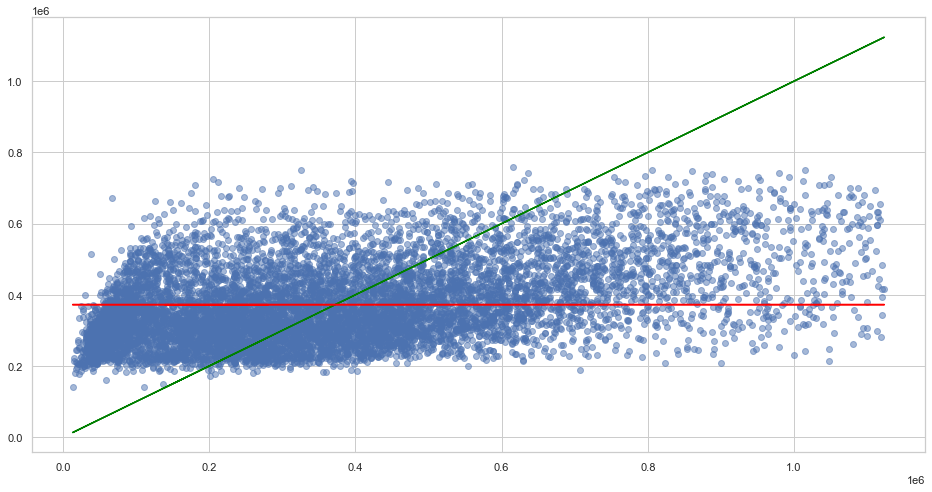

In [31]:
plt.figure(figsize = (16, 8))
plt.plot(predictions_test.actual, predictions_test.actual, color = 'green')
plt.plot(predictions_test.actual, predictions_test.baseline_mean, color = 'red')
plt.scatter(predictions_test.actual, predictions_test.ols_test, alpha = 0.5)
plt.annotate('Ideal: Actual Assessed Value', (1.2*10**6, 1.25*10**6), rotation = 25)
plt.annotate('Baseline: Mean Tax Value', (1.25*10**6, .3*10**6), color = 'red')
plt.show()

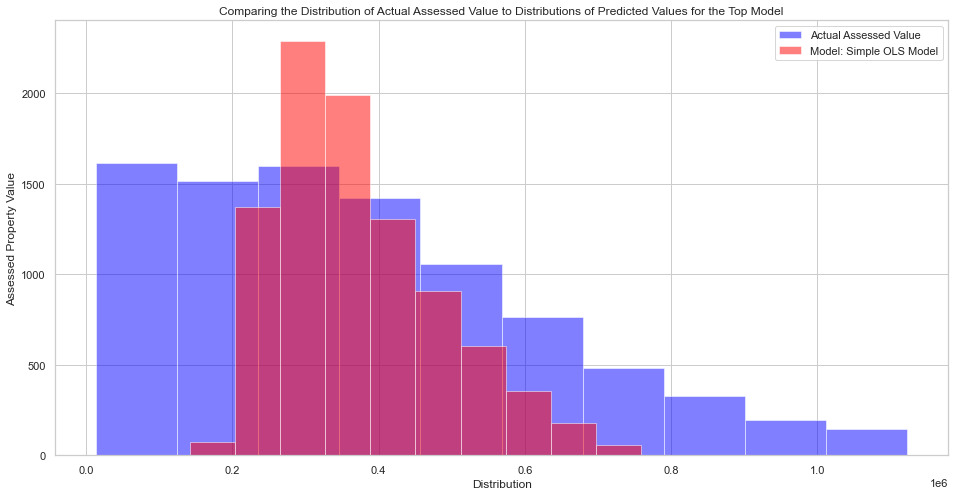

In [32]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(predictions_test.actual, color='blue', alpha=.5, label="Actual Assessed Value")
plt.hist(predictions_test.ols_test, color='red', alpha=.5, label="Model: Simple OLS Model")
plt.xlabel("Distribution")
plt.ylabel("Assessed Property Value")
plt.title("Comparing the Distribution of Actual Assessed Value to Distributions of Predicted Values for the Top Model")
plt.legend()
plt.show()